# Lecture 2 - Performance tips

## Keep track of your code
**Julia's profiler also allows you to hunt for bottlenecks.**
- `@profile`
**Julia's timer tracks running time and memory usage.**
- `@time`
- Do not store unnecessary output!

In [1]:
using Profile

function test(x::Float64)
    for i = 1:10000000
        x+=i #do a bunch of things to x
        x-=i
        x*=i
        x/=i
        x = abs(x)
        x = log(x)
    end
    x
end

test (generic function with 1 method)

In [2]:
test(2.0)

-0.8466947489163474

In [3]:
Profile.clear() #empty the profile
@profile test(2.0) #profile a call of test function
Profile.print() #print profile

Overhead ╎ [+additional indent] Count File:Line; Function
   ╎248 @Base/task.jl:411; (::IJulia.var"#15#18")()
   ╎ 248 @IJulia/src/eventloop.jl:8; eventloop(socket::ZMQ.Socket)
   ╎  248 @Base/essentials.jl:706; invokelatest
   ╎   248 @Base/essentials.jl:708; #invokelatest#2
   ╎    248 .../execute_request.jl:67; execute_request(socket::ZMQ.So...
   ╎     248 .../SoftGlobalScope.jl:65; softscope_include_string(m::Mo...
   ╎    ╎ 248 @Base/loading.jl:1116; include_string(mapexpr::type...
  3╎    ╎  248 @Base/boot.jl:360; eval
   ╎    ╎   2   In[1]:5; test(x::Float64)
   ╎    ╎    2   @Base/promotion.jl:321; +
   ╎    ╎     2   @Base/promotion.jl:292; promote
   ╎    ╎    ╎ 2   @Base/promotion.jl:269; _promote
   ╎    ╎    ╎  2   @Base/number.jl:7; convert
  2╎    ╎    ╎   2   @Base/float.jl:94; Float64
   ╎    ╎   8   In[1]:6; test(x::Float64)
   ╎    ╎    8   @Base/promotion.jl:323; -
  8╎    ╎     8   @Base/float.jl:329; -
   ╎    ╎   13  In[1]:7; test(x::Float64)
   ╎    ╎    13  @B

Two alternatives to `@profile`:

In [12]:
# using Pkg; Pkg.add("StatProfilerHTML")
using StatProfilerHTML

@profilehtml test(2.0) #profile a call of test function

┌ Info: Wrote profiling output to file:///home/mitchv34/2021_Summer_Computational_Economics_Bootcamp/Lectures in Jupyter/statprof/index.html .
└ @ StatProfilerHTML /home/mitchv34/.julia/packages/StatProfilerHTML/OFVct/src/StatProfilerHTML.jl:49


-0.8466947489163474

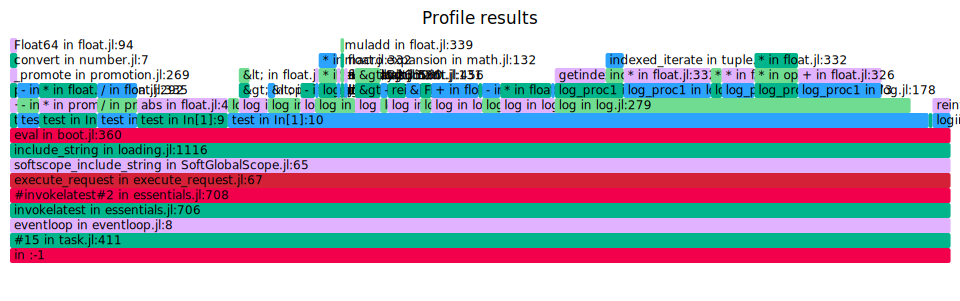

In [10]:
# using Pkg; Pkg.add("ProfileSVG")
using ProfileSVG

@profview test(2.0) #profile a call of test function

In [22]:
## Time a function
@time test(2.0)

  0.246265 seconds


-0.8466947489163474

The package `BenchmarkTools` provedes an excellent alternative to `@time`.

In [19]:
# using Pkg; Pkg.add("BenchmarkTools")
using BenchmarkTools

In [25]:
@benchmark test(2.0)

BenchmarkTools.Trial: 20 samples with 1 evaluation.
 Range (min … max):  246.751 ms … 275.033 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     253.955 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   255.390 ms ±   7.589 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▃   ▃   ▃                 █                                    
  █▇▁▁█▇▁▇█▁▁▁▁▇▁▁▁▇▁▁▇▁▁▁▁▁█▁▇▇▁▁▁▁▁▁▁▁▇▁▁▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇ ▁
  247 ms           Histogram: frequency by time          275 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

`@time` measure the running time of a functionm while `@benchmark` do several runs and and retunr some statistics. Since runing  time of a function is a random variable that can  be affected by many factors, it is not possible to compare the running time of two functions using just `@time`.

## Vectorization
Vectorization **does** make your code run faster.

In [17]:
temp = 1:10000000 |> collect
@benchmark temp.+ 1

BenchmarkTools.Trial: 238 samples with 1 evaluation.
 Range (min … max):  14.146 ms … 50.247 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     19.549 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   20.952 ms ±  5.601 ms  ┊ GC (mean ± σ):  4.05% ± 5.91%

       ▂█▃▃▂▂▃▂                                                
  ▅▇▇█▆████████▄▆▆▄▅▇▄▄▆▄▁▄▄▃▁▄▄▁▁▃▁▁▃▃▃▁▁▁▁▃▁▁▁▃▁▃▁▁▁▁▁▁▁▁▁▃ ▃
  14.1 ms         Histogram: frequency by time        46.2 ms <

 Memory estimate: 76.29 MiB, allocs estimate: 4.

In [18]:
temp = 1:10000000 |> collect
@benchmark for i in temp
    i+=1
end

BenchmarkTools.Trial: 7 samples with 1 evaluation.
 Range (min … max):  713.398 ms … 854.990 ms  ┊ GC (min … max): 8.05% … 8.99%
 Time  (median):     729.122 ms               ┊ GC (median):    9.44%
 Time  (mean ± σ):   770.689 ms ±  63.070 ms  ┊ GC (mean ± σ):  8.80% ± 0.52%

  █ ██  █                                      █       █      █  
  █▁██▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁█▁▁▁▁▁▁█ ▁
  713 ms           Histogram: frequency by time          855 ms <

 Memory estimate: 762.92 MiB, allocs estimate: 39998469.

In [1]:
## show off compilation
function f(a, b)
    y = (a + 8b)^2
    return 7y
end
f(1, 2)

2023

In [2]:
@code_native f(1, 2)  #view machine code generate by Julia

	.text
; ┌ @ In[1]:2 within `f'
; │┌ @ int.jl:87 within `+'
	leaq	(%rdi,%rsi,8), %rcx
; │└
; │┌ @ intfuncs.jl:313 within `literal_pow'
; ││┌ @ int.jl:88 within `*'
	imulq	%rcx, %rcx
; │└└
; │ @ In[1]:3 within `f'
; │┌ @ int.jl:88 within `*'
	leaq	(,%rcx,8), %rax
	subq	%rcx, %rax
; │└
	retq
	nopw	%cs:(%rax,%rax)
; └


## Scope of Variables 

**Avoid global variables.**
- A global variable can be changed anytime, anywhere, inside or outside a function.
- Difficult for the compiler to optimize code using global variables!

**Global constants are acceptable.**
- E.g., beta $=0.9$, etc.

**Type declarations can help complier optimize performance.**
- Type declarations make code run faster in many languages.
- Not necessary in Julia because variable types can be inferred by compiler.
- Can help in some cases in Julia.
- Use function `f(x::Array{Float64,2})` instead of function `f(x)`

In [15]:
function f(x)
    return 2 * x
end

function f!(out, x) # example of a wrong function
    return out = 2 * x
end

f! (generic function with 1 method)

In [16]:
y=ones(2); 
out = [1000;1000];
out1 = f(y)
f!(out,y); out

# The result is supposed to be 2 instead of the initial value of `out`. The f!() function works as follows:
    # create a temporary variable = 2*x
    # assign a local name `out` to it
    # the temporary variable is not pushed to the input `out` so nothing is modified

2-element Vector{Int64}:
 1000
 1000

In [17]:
# To correct for this error,
# Method 1: make the temporary variable 2*x global
function f1!(out, x)
    global out = 2 * x
end
out = [1000;1000];
f1!(out,y); out

2-element Vector{Float64}:
 2.0
 2.0

In [18]:
 # Method 2: copy the value instead of assign the name
 function f2!(out, x)
    return out[:] = 2 * x
end
out = [1000;1000];
f2!(out,y); out

2-element Vector{Int64}:
 2
 2

Next we will compare in terms of performance two functions that do exactly the same thing but one uses a global variable and the other recieves the value as a parameter.

In [22]:
global a = 1

function f3() 
    for i = 1:10^6
        global a += 1
    end
    return a
end

@benchmark f3()

BenchmarkTools.Trial: 260 samples with 1 evaluation.
 Range (min … max):  15.033 ms … 53.952 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     17.858 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   19.248 ms ±  5.053 ms  ┊ GC (mean ± σ):  4.45% ± 6.10%

   ▂▂▆█▁▂▃▂ ▁                                                  
  ▅████████▆█▄▄▆▄▁▅▄▃▄▃▃▁▃▃▂▁▃▂▁▁▁▁▁▃▁▂▁▁▂▂▁▁▂▁▁▂▁▁▃▁▁▁▁▁▁▁▁▂ ▃
  15 ms           Histogram: frequency by time          39 ms <

 Memory estimate: 15.26 MiB, allocs estimate: 1000000.

In [24]:
function f4(a)
    for i = 1:10^6
        global a += 1
    end
    return a
end

@benchmark f(1)

BenchmarkTools.Trial: 10000 samples with 1000 evaluations.
 Range (min … max):  0.001 ns … 16.600 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     0.100 ns              ┊ GC (median):    0.00%
 Time  (mean ± σ):   0.103 ns ±  0.298 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

                              █                               
  ▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃ ▂
  01 ns          Histogram: frequency by time         0.2 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

Clearly the use of a global variable is not a good idea.

In Julia a function can have different methods this is called multiple dispatch.

In [25]:
function mult_dist_example(a::String, b::String)
    return a*" and "*b
end

function mult_dist_example(a::Int, b::Int)
    return a + b
end

function mult_dist_example(a,b)
    return (typeof(a), typeof(b))
end

mult_dist_example (generic function with 3 methods)

`mult_disp_example` is a function with 3 methods that behaves diferently depending on the type of the input.

In [26]:
mult_dist_example("A String", "Another String")

"A String and Another String"

In [27]:
mult_dist_example(1,2)

3

In [28]:
mult_dist_example(1.0, [2])

(Float64, Vector{Int64})

In [29]:
# to see whet methods are defined for a function use
methods(mult_dist_example)

# 3 methods for generic function "mult_dist_example":
[1] mult_dist_example(a::String, b::String) in Main at In[25]:1
[2] mult_dist_example(a::Int64, b::Int64) in Main at In[25]:5
[3] mult_dist_example(a, b) in Main at In[25]:9

In [30]:
# The sum function has a lot of methods defined
methods(+)

# 192 methods for generic function "+":
[1] +(x::T, y::T) where T<:Union{Int128, Int16, Int32, Int64, Int8, UInt128, UInt16, UInt32, UInt64, UInt8} in Base at int.jl:87
[2] +(c::Union{UInt16, UInt32, UInt64, UInt8}, x::BigInt) in Base.GMP at gmp.jl:528
[3] +(c::Union{Int16, Int32, Int64, Int8}, x::BigInt) in Base.GMP at gmp.jl:534
[4] +(c::Union{UInt16, UInt32, UInt64, UInt8}, x::BigFloat) in Base.MPFR at mpfr.jl:376
[5] +(c::Union{Int16, Int32, Int64, Int8}, x::BigFloat) in Base.MPFR at mpfr.jl:384
[6] +(c::Union{Float16, Float32, Float64}, x::BigFloat) in Base.MPFR at mpfr.jl:392
[7] +(x::Union{Dates.CompoundPeriod, Dates.Period}) in Dates at /home/mitchv34/Julia/share/julia/stdlib/v1.6/Dates/src/periods.jl:362
[8] +(a::Union{ColorTypes.LMS, ColorTypes.XYZ}, b::Union{ColorTypes.LMS, ColorTypes.XYZ}) in Colors at /home/mitchv34/.julia/packages/Colors/yDxFN/src/algorithms.jl:4
[9] +(y::AbstractFloat, x::Bool) in Base at bool.jl:102
[10] +(A::LinearAlgebra.Bidiagonal, B::LinearAlgebra.Bidiagonal) in LinearAlgebra at /home/mitchv34/Julia/share/julia/stdlib/v1.6/LinearAlgebra/src/bidiag.jl:354
[11] +(A::LinearAlgebra.Bidiagonal, B::LinearAlgebra.UpperTriangular) in LinearAlgebra at /home/mitchv34/Julia/share/julia/stdlib/v1.6/LinearAlgebra/src/special.jl:94
[12] +(A::LinearAlgebra.Bidiagonal, B::LinearAlgebra.UnitUpperTriangular) in LinearAlgebra at /home/mitchv34/Julia/share/julia/stdlib/v1.6/LinearAlgebra/src/special.jl:94
[13] +(A::LinearAlgebra.Bidiagonal, B::LinearAlgebra.LowerTriangular) in LinearAlgebra at /home/mitchv34/Julia/share/julia/stdlib/v1.6/LinearAlgebra/src/special.jl:94
[14] +(A::LinearAlgebra.Bidiagonal, B::LinearAlgebra.UnitLowerTriangular) in LinearAlgebra at /home/mitchv34/Julia/share/julia/stdlib/v1.6/LinearAlgebra/src/special.jl:94
[15] +(A::LinearAlgebra.Bidiagonal, B::LinearAlgebra.Diagonal) in LinearAlgebra at /home/mitchv34/Julia/share/julia/stdlib/v1.6/LinearAlgebra/src/special.jl:115
[16] +(A::LinearAlgebra.Bidiagonal, B::LinearAlgebra.Tridiagonal) in LinearAlgebra at /home/mitchv34/Julia/share/julia/stdlib/v1.6/LinearAlgebra/src/special.jl:183
[17] +(A::LinearAlgebra.Bidiagonal, B::LinearAlgebra.SymTridiagonal) in LinearAlgebra at /home/mitchv34/Julia/share/julia/stdlib/v1.6/LinearAlgebra/src/special.jl:203
[18] +(A::LinearAlgebra.Bidiagonal{var"#s832", V} where {var"#s832"<:Number, V<:AbstractVector{var"#s832"}}, B::LinearAlgebra.UniformScaling) in LinearAlgebra at /home/mitchv34/Julia/share/julia/stdlib/v1.6/LinearAlgebra/src/special.jl:236
[19] +(J::LinearAlgebra.UniformScaling) in LinearAlgebra at /home/mitchv34/Julia/share/julia/stdlib/v1.6/LinearAlgebra/src/uniformscaling.jl:150
[20] +(J::LinearAlgebra.UniformScaling, x::Number) in LinearAlgebra at /home/mitchv34/Julia/share/julia/stdlib/v1.6/LinearAlgebra/src/uniformscaling.jl:145
[21] +(J1::LinearAlgebra.UniformScaling, J2::LinearAlgebra.UniformScaling) in LinearAlgebra at /home/mitchv34/Julia/share/julia/stdlib/v1.6/LinearAlgebra/src/uniformscaling.jl:151
[22] +(J::LinearAlgebra.UniformScaling, B::BitMatrix) in LinearAlgebra at /home/mitchv34/Julia/share/julia/stdlib/v1.6/LinearAlgebra/src/uniformscaling.jl:153
[23] +(J::LinearAlgebra.UniformScaling, F::LinearAlgebra.Hessenberg) in LinearAlgebra at /home/mitchv34/Julia/share/julia/stdlib/v1.6/LinearAlgebra/src/hessenberg.jl:560
[24] +(A::LinearAlgebra.UniformScaling, B::LinearAlgebra.Tridiagonal{var"#s832", V} where {var"#s832"<:Number, V<:AbstractVector{var"#s832"}}) in LinearAlgebra at /home/mitchv34/Julia/share/julia/stdlib/v1.6/LinearAlgebra/src/special.jl:245
[25] +(A::LinearAlgebra.UniformScaling, B::LinearAlgebra.SymTridiagonal{var"#s832", V} where {var"#s832"<:Number, V<:AbstractVector{var"#s832"}}) in LinearAlgebra at /home/mitchv34/Julia/share/julia/stdlib/v1.6/LinearAlgebra/src/special.jl:250
[26] +(A::LinearAlgebra.UniformScaling, B::LinearAlgebra.Bidiagonal{var"#s832", V} where {var"#s832"<:Number, V<:AbstractVector{var"#s832"}}) in LinearAlgebra at /home/mitchv34/Julia/share/

Finally we will compare the performance of the two functions that do the same thin but one has type declarations and the other does not.

In [31]:
function type_dec(a::Float64, b::Float64)
    for i = 1:10^6
        a +=1
        b +=1
    end
    return a/b
end

type_dec (generic function with 1 method)

In [32]:
function no_type_dec(a, b)
    for i = 1:10^6
        a +=1
        b +=1
    end
    return a/b
end

no_type_dec (generic function with 1 method)

In [33]:
@benchmark type_dec(2.0, 4.0)

BenchmarkTools.Trial: 5217 samples with 1 evaluation.
 Range (min … max):  818.300 μs …   3.680 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     911.600 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   948.794 μs ± 143.070 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▅█▄▄▆▄▃▃▃▃▆▅▃▃▃▃▃▃▃▂▂▁▂▂▂▁▁▁▁                                ▁
  ▇██████████████████████████████████▇█▇▇▇▇▇▇▅▇▇▇▇▆▆▄▅▆▅▅▄▆▆▄▅▆ █
  818 μs        Histogram: log(frequency) by time       1.44 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [34]:
@benchmark no_type_dec(2.0, 4.0)

BenchmarkTools.Trial: 5284 samples with 1 evaluation.
 Range (min … max):  818.300 μs …   3.693 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     876.400 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   936.325 μs ± 132.125 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▅█▄▄▆▅▃▃▂▂▂▃▃▃▂▃▂▂▂▂▂▂▂▁▂▁▂▁▂▁▁▁                             ▁
  ██████████████████████████████████▇█▇▇▇▇▆█▆▆▅▇▆▆▇▆▆▅▅▅▄▅▅▆▅▅▅ █
  818 μs        Histogram: log(frequency) by time        1.4 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

## Nothing, NaN, and Missing
Sometimes the results are absent. You can use a value `nothing` of Type "Nothing".

In [36]:
# function f(x)
#     if x >=0
#         return sqrt(x)
#     else
#         return nothing
#     end
# end

# There is a more concise way to write this function

f(x) = (x >= 0) ? sqrt(x) : nothing

f(4)


2.0

In [37]:
f(-2) # return nothing

In [38]:
typeof(f(-23))

Nothing

In [39]:
f(-233) == nothing

true

In [41]:
f(-233) === nothing # When comparing against `nothing`, `===` is better used

true

In [45]:
### More often, we use NaN
### NaN (not a number) is trikier. For example, Inf/Inf = NaN
exp(1000)
exp(1000)/exp(1000)

NaN

In [46]:
# keep in mind to use isnan() to check whether an object is NaN
isnan(NaN)

true

In [47]:
NaN == NaN # is always false

false

In [48]:
### The value missing of type Missing is used to represent missing value in a statistical sense (similar to "." in Stata).
x = [3.0, missing, 5.0, missing, missing]

5-element Vector{Union{Missing, Float64}}:
 3.0
  missing
 5.0
  missing
  missing

In [50]:
x .+ 10 # missing values are ignored when broadcasting


5-element Vector{Union{Missing, Float64}}:
 13.0
   missing
 15.0
   missing
   missing

In [55]:
map(i -> i^2 + 2, x)

5-element Vector{Union{Missing, Float64}}:
 11.0
   missing
 27.0
   missing
   missing

In [57]:
using Statistics

In [58]:
mean(x) # Means with missing values is missing

missing

In [62]:
mean( skipmissing(x) ) # use `skipmissing` to skip missing values

4.0

In [64]:
coalesce.(x, 0) # use `coalesce` to replace missing values with a default value)

5-element Vector{Real}:
 3.0
 0
 5.0
 0
 0

In [66]:
mean( coalesce.(x, 0.0) ) 

1.6

# Optimal Savings Model
* Household preference: $$u(c) = \log(c)$$
* Production technology: $$y = k^\theta$$
* Capital depreciation rate: $$\delta$$
* Budget constraint: $$c + k' = k^\theta + (1-\delta)k$$

## Dynamic programming problem:
 $$V(k) = \max_{k'} \left\{ u(c) + \beta V(k')\right\} \quad \text{s.t.} \quad c + k' = k^\theta + (1-\delta)k$$

- Solve the problem and plot the policy function $k' = k'(k)$
- Guess $V(k')$, get $V(k)$ (function `Bellman()` below)
- Iterate until the function converge (function `Solve_model()` below)


In [69]:
# using Pkg; Pkg.add("Parameters"); Pkg.add("Plots")
using Parameters, Plots

# struct to hold model primitives (global constants)
@with_kw struct Primitives
    β::Float64 = 0.99 #discount factor
    θ::Float64 = 0.36 #production
    δ::Float64 = 0.025 #depreciation
    k_grid::Array{Float64,1} = collect(range(0.1, length = 1800, stop= 45.0)) #capital grid
    nk::Int64 = length(k_grid) #number of capital grid states
end

# struct to hold model outputs
mutable struct Results
    val_func::Array{Float64,1} #value function
    pol_func::Array{Float64,1} #policy function
end

In [70]:
#Bellman operator
function Bellman(prim::Primitives, res::Results)
    @unpack β, δ, θ, nk, k_grid = prim #unpack primitive structure
    v_next = zeros(nk) #preallocate next guess of value function

    for i_k = 1:nk #loop over state space
        max_util = -1e10
        k = k_grid[i_k] #value of capital
        budget = k^θ + (1-δ)*k #budget

        for i_kp = 1:nk #loop over choice set, find max {log(c) + β * res.val_func[i_kp]}
            kp = k_grid[i_kp] #value of k'
            c = budget - kp #consumption
            if c>0 #check if postiive
                val = log(c) + β * res.val_func[i_kp] #compute utility
                if val > max_util #wow new max!
                    max_util = val #reset max value
                    res.pol_func[i_k] = kp #update policy function
                end
            end
        end
        v_next[i_k] = max_util #update value function
    end
    v_next
end

Bellman (generic function with 1 method)

In [78]:
#function to solve the model
function Solve_model()
    #initialize primitives and results
    prim = Primitives()
    val_func, pol_func = zeros(prim.nk), zeros(prim.nk)
    res = Results(val_func, pol_func)

    error, n = 100, 0
    while error>0.0001 #loop until convergence
        n+=1
        v_next = Bellman(prim, res) #next guess of value function
        error = maximum(abs.(v_next .- res.val_func)) #check for convergence
        res.val_func = v_next #update
        # I will comment the printing of the error, it looks bad in Jupyter
        # println("Current error: ", error) 
    end
    println("Value function converged in ", n, " iterations")
    prim, res
end

Solve_model (generic function with 1 method)

In [79]:
@elapsed prim, res = Solve_model() #solve the model.

Value function converged in 908 iterations


16.1779873

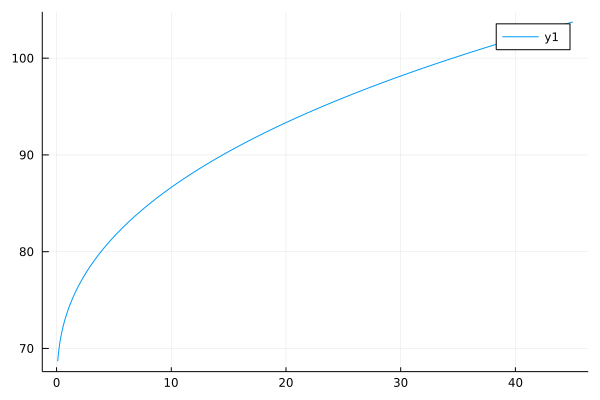

In [77]:
Plots.plot(prim.k_grid, res.val_func) #plot value function
